# import 

In [1]:
from glob import glob
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

# preprocessing

In [2]:
path = './data/train/'
images = []
labels = []
for filename in glob(path + '*'): # 폴더(라벨) 경로
    for img in glob(filename + '/*.jpg'): # 개별 이미지 경로
        img_open = Image.open(img) # 이미지 로드
        img_arr = np.array(img_open) # 배열화
        images.append(img_arr)
        
        label = filename.split('\\')[1] # 라벨 추출
        labels.append(label)

In [3]:
train_images = np.array(images)
train_labels = np.array(labels)

train_images.shape, train_labels.shape

((50000, 32, 32, 3), (50000,))

In [4]:
oe = OneHotEncoder(sparse=False)
oe.fit(train_labels.reshape(-1, 1))

OneHotEncoder(sparse=False)

In [5]:
path = './data/test/'
images = []
test_idx = []
flist = sorted(glob(path + '*.jpg'))
for filename in flist:
    img_open = Image.open(img) # 이미지 로드
    img_arr = np.array(img_open) # 배열화
    images.append(img_arr)
    
    label = filename.split('\\')[1] # 라벨 추출
    test_idx.append(label)

test_images = np.array(images)

test_images.shape, test_idx[:5]

((10000, 32, 32, 3),
 ['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg'])

# train

In [6]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, stratify=train_labels, random_state=0)

y_train = oe.transform(y_train.reshape(-1, 1))
y_val = oe.transform(y_val.reshape(-1, 1))

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 10), (10000, 10))

In [8]:
def scaling(x, y):
    x = tf.cast(x, dtype=tf.float32)
    x /= 255.
    return x, y

batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(scaling).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).map(scaling).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
for i in train_ds.take(1):
    sample = i
sample[0].shape, sample[1][:5]

(TensorShape([32, 32, 32, 3]),
 <tf.Tensor: shape=(5, 10), dtype=float64, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])>)

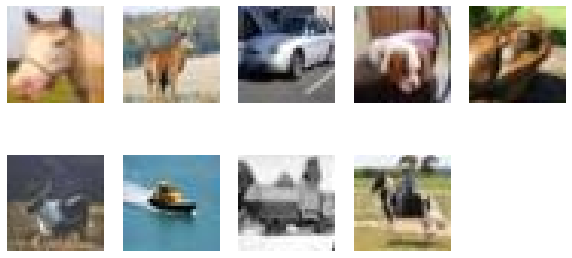

In [12]:
plt.figure(figsize=(10, 5))
for i in range(9):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(sample[0][i].numpy())
    plt.axis('off')

# modeling

In [17]:
def conv_layers(filters, filter_size, stride, padding, pooling, name=None):
    conv = keras.models.Sequential(
        [
            keras.layers.Conv2D(filters, filter_size, strides=stride, padding=padding, use_bias=False),
            keras.layers.BatchNormalization(),
            keras.layers.Activation('relu')
        ],
        name='conv_block' + str(name)
    )
    if pooling:
        conv.add(keras.layers.MaxPool2D(2, padding='same'))
    return conv

def aug_func(data):
    out = tf.image.random_brightness(data, 0.5)
    out = tf.image.random_saturation(out, 3, 10)
    return out

In [18]:
data_augmentation = keras.Sequential(
    [
        keras.layers.Lambda(lambda x: aug_func(x)), 
        keras.layers.experimental.preprocessing.RandomRotation(0.2),
        keras.layers.experimental.preprocessing.RandomFlip(),
        keras.layers.experimental.preprocessing.RandomContrast(0.3)
    ], 
    name='aug_layer'
)

In [19]:
tf.random.set_seed(0)

model = keras.models.Sequential(
    [
        keras.layers.Input(shape=X_train.shape[1:]),
        data_augmentation,
        conv_layers(64, 3, 1, 'same', False, 1), 
        conv_layers(64, 3, 1, 'same', False, 2), 
        conv_layers(64, 3, 1, 'same', True, 3), 
        conv_layers(128, 3, 1, 'same', False, 4), 
        conv_layers(128, 3, 1, 'same', False, 5), 
        conv_layers(128, 3, 1, 'same', False, 6), 
        conv_layers(256, 3, 1, 'same', False, 7), 
        conv_layers(256, 3, 1, 'same', False, 8), 
        conv_layers(256, 3, 1, 'same', True, 9), 
        conv_layers(512, 3, 1, 'same', False, 10), 
        conv_layers(512, 3, 1, 'same', False, 11), 
        conv_layers(512, 3, 1, 'same', False, 12), 
        conv_layers(1024, 3, 1, 'same', False, 13), 
        conv_layers(1024, 3, 1, 'same', False, 14), 
        conv_layers(1024, 3, 1, 'same', False, 15), 
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(10, activation='softmax')
    ]
)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 aug_layer (Sequential)      (None, 32, 32, 3)         0         
                                                                 
 conv_block1 (Sequential)    (None, 32, 32, 64)        1984      
                                                                 
 conv_block2 (Sequential)    (None, 32, 32, 64)        37120     
                                                                 
 conv_block3 (Sequential)    (None, 16, 16, 64)        37120     
                                                                 
 conv_block4 (Sequential)    (None, 16, 16, 128)       74240     
                                                                 
 conv_block5 (Sequential)    (None, 16, 16, 128)       147968    
                                                                 
 conv_block6 (Sequential)    (None, 16, 16, 128)      

In [22]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./ckpt/cnn',
        monitor='val_accuracy',
        mode='max',
        save_weights_only=True,
        save_best_only=True,
        verbose=1
    )
]

hist = model.fit(
    train_ds, validation_data=val_ds,
    epochs=100, callbacks=callbacks
)

Epoch 1/100
   7/1250 [..............................] - ETA: 14:13:39 - loss: 3.2003 - accuracy: 0.1295

KeyboardInterrupt: 